In [1]:
import pandas as pd
import math
from functools import reduce
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
main_df = pd.read_excel('C:/Users/lzoeckler/Desktop/decay/DBS_stability_2.xlsx')
main_df.rename(columns={'Unnamed: 0': 'analyte', 'Unnamed: 1': 'treatment_condition',
                       'Unnamed: 2': 'time_or_humidity'}, inplace=True)
main_df.loc[main_df['analyte'] == 'Pv LDH', 'analyte'] = 'Pv_LDH'
main_df.loc[main_df['analyte'] == 'Pf LDH', 'analyte'] = 'Pf_LDH'
main_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
0,HRP2,-20oC,1.0,1546.99,806.53,79.33
1,HRP2,-20oC,3.0,1300.62,791.51,64.99
2,HRP2,-20oC,7.0,1582.84,897.24,88.90
3,HRP2,-20oC,15.0,1547.39,691.08,67.17
4,HRP2,-20oC,30.0,1648.93,927.27,93.60


In [3]:
main_df['analyte'].unique()

array(['HRP2', 'Pv_LDH', 'Pf_LDH', 'CRP'], dtype=object)

In [4]:
def temp_adjust(df):
    temp = df['treatment_condition']
    temp = temp.replace("oC", "")
    temp = int(temp)
    return temp

In [5]:
time_df = main_df.loc[main_df['treatment_condition'] != 'Humidity']
time_df['treatment_condition'] = time_df.apply(temp_adjust, axis=1)
time_df['treatment_condition'].unique()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([-20,   4,  23,  30,  50], dtype=int64)

In [6]:
time_df['time_or_humidity'].unique()

array([  1.,   3.,   7.,  15.,  30.,  60., 120., 240.])

In [7]:
time_df.loc[(time_df['treatment_condition'] == 4)
            & (time_df['analyte'] == 'Pf_LDH')]

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
48,Pf_LDH,4,1.0,14046.28,8512.34,699.70
49,Pf_LDH,4,3.0,10830.68,6827.24,733.67
50,Pf_LDH,4,7.0,12851.85,6780.80,1020.71
51,Pf_LDH,4,15.0,10828.34,6620.00,717.24
52,Pf_LDH,4,30.0,11073.76,7259.36,726.47
53,Pf_LDH,4,60.0,9051.57,6087.39,734.50
54,Pf_LDH,4,120.0,10267.39,5463.79,567.97
55,Pf_LDH,4,240.0,8830.77,5670.04,642.13


In [8]:
base_value_df = time_df.loc[time_df['treatment_condition'] == -20]
base_value_df = base_value_df.groupby(['analyte', 'treatment_condition']).mean().reset_index()
base_value_df.drop(['treatment_condition', 'time_or_humidity'], axis=1, inplace=True)
base_value_df

,analyte,Hi,Med,Low
0,CRP,17950.92500,7628.23500,699.82500
1,HRP2,1534.43625,825.94375,83.70375
2,Pf_LDH,12022.15500,6948.41500,796.22750
3,Pv_LDH,4976.20875,2897.74000,312.14625


In [9]:
time_df = time_df.loc[time_df['treatment_condition'] != -20]
time_df = time_df.merge(base_value_df, on='analyte', suffixes=('', '_base'))
time_df.head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
0,HRP2,4,1.0,1937.11,1006.40,79.08,1534.43625,825.94375,83.70375
1,HRP2,4,3.0,1438.96,875.57,76.59,1534.43625,825.94375,83.70375
2,HRP2,4,7.0,1748.31,945.54,105.97,1534.43625,825.94375,83.70375
3,HRP2,4,15.0,1563.24,809.20,73.14,1534.43625,825.94375,83.70375
4,HRP2,4,30.0,1716.19,1039.20,222.44,1534.43625,825.94375,83.70375


In [ ]:
analyte: Pf_LDH, concentration: Hi, temp: 50, base_half: 6011.077499999999, closest_val: [[4152.50523804]], half life: 0

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

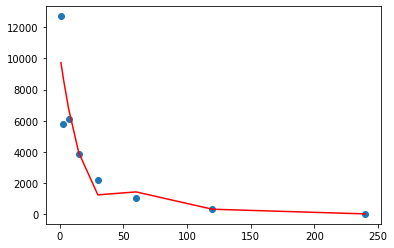

In [46]:
dfs = []
#for analyte in time_df['analyte'].unique():
for analyte in ['Pf_LDH']:
    an_df = time_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Hi']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [50]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=4)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            regr.fit(poly_time, con)
            pred = regr.predict(poly_time)
            plt.scatter(time, con)
            plt.plot(time, pred, color='red')
            plt.show()

In [47]:
regr.predict(poly.fit_transform([[0]]))

array([[10294.31717402]])

In [48]:
base_val / 2

6011.077499999999

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

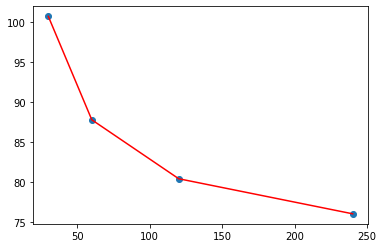

In [34]:
test_df = time_df.copy(deep=True)
test_df = test_df.loc[test_df['time_or_humidity'] > 15]
#for analyte in time_df['analyte'].unique():
for analyte in ['HRP2']:
    an_df = test_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [23]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=3)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            regr.fit(poly_time, con)
            pred = regr.predict(poly_time)
            plt.scatter(time, con)
            plt.plot(time, pred, color='red')
            plt.show()

In [37]:
regr.predict(poly.fit_transform([[301]]))

array([[41.94337935]])

In [38]:
base_val / 2

41.851875

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pand

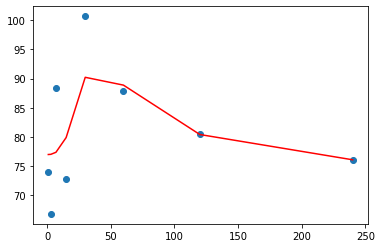

In [27]:
#for analyte in time_df['analyte'].unique():
for analyte in ['HRP2']:
    an_df = time_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [23]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=6)
            regr = linear_model.BayesianRidge(compute_score=True)
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            regr.fit(poly_time, con)
            pred = regr.predict(poly_time)
            plt.scatter(time, con)
            plt.plot(time, pred, color='red')
            plt.show()

In [174]:
np.ndarray([1,2,3,3])

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

In [120]:
def fourth_degree(x, a, b, c, d, e):
    return(a + (b * x) + (c * x ** 2) + (d * x ** 3) + (e * x ** 4))

In [121]:
def third_degree(x, a, b, c, d):
    return(a + (b * x) + (c * x ** 2) + (d * x ** 3) )

In [125]:
def second_degree(x, a, b, c):
    return(a + (b * x) + (c * x ** 2))

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


[ 2.64886792e-05 -9.88266325e-03  8.63329187e-01  7.20247259e+01]
[ 7.20247257e+01  8.63329223e-01 -9.88266373e-03  2.64886806e-05]


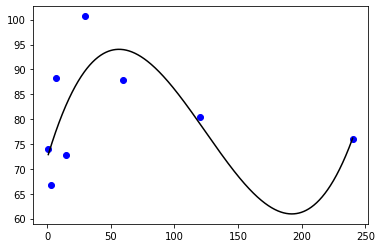

In [159]:
test_df = time_df.copy(deep=True)
#test_df = test_df.loc[test_df['time_or_humidity'] > 15]
#for analyte in time_df['analyte'].unique():
for analyte in ['HRP2']:
    an_df = test_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [23]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            x = temp_df['time_or_humidity'].tolist()
            y = temp_df[concentration].tolist()
            print(np.polyfit(x, y, 3))
            popt, _ = curve_fit(third_degree, x, y)
            print(popt)
            xnew = np.linspace(x[0], x[-1], 1000)
            plt.plot(x, y, 'bo')
            plt.plot(xnew, third_degree(xnew, *popt), 'black')
            plt.show()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lzoeckler\mini

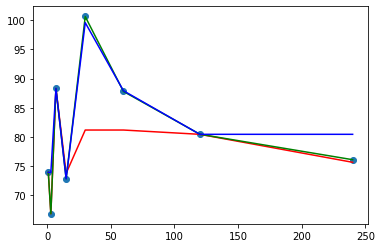

In [115]:
#for analyte in time_df['analyte'].unique():
for analyte in ['HRP2']:
    an_df = time_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [23]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=4)
            # Set lower and upper quantile
            LOWER_ALPHA = 0.4
            UPPER_ALPHA = 0.6
            # Each model has to be separate
            lower_model = GradientBoostingRegressor(loss="quantile",                   
                                                    alpha=LOWER_ALPHA)
            # The mid model will use the default loss
            mid_model = GradientBoostingRegressor(loss="ls")
            upper_model = GradientBoostingRegressor(loss="quantile",
                                                    alpha=UPPER_ALPHA)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            lower_model.fit(poly_time, con)
            mid_model.fit(poly_time, con)
            upper_model.fit(poly_time, con)
            lower_pred = lower_model.predict(poly_time)
            mid_pred = mid_model.predict(poly_time)
            upper_pred = upper_model.predict(poly_time)
            plt.scatter(time, con)
            plt.plot(time, lower_pred, color='red')
            plt.plot(time, mid_pred, color='green')
            plt.plot(time, upper_pred, color='blue')
            plt.show()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

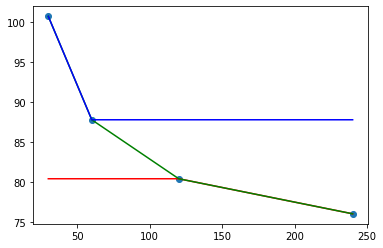

In [95]:
test_df = time_df.copy(deep=True)
test_df = test_df.loc[test_df['time_or_humidity'] > 15]
#for analyte in time_df['analyte'].unique():
for analyte in ['HRP2']:
    an_df = test_df.loc[time_df['analyte'] == analyte]
    #for concentration in ['Hi', 'Med', 'Low']:
    for concentration in ['Low']:
        con_df = an_df[['treatment_condition', 'time_or_humidity',
                        concentration, '{}_base'.format(concentration)]]
        end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
        end_df['decay'] = True
        end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
        end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
        con_df = con_df.merge(end_df, on=['treatment_condition'])
        calc_df = con_df.loc[con_df['decay'] == True]
        base_val = calc_df['{}_base'.format(concentration)].tolist()[0]
        #for temp in an_df['treatment_condition'].unique():
        for temp in [23]:
            temp_df = calc_df.loc[calc_df['treatment_condition'] == temp]
            temp_df.drop(['decay', 'treatment_condition', '{}_base'.format(concentration)], axis=1, inplace=True)
            poly = PolynomialFeatures(degree=3)
            # Set lower and upper quantile
            LOWER_ALPHA = 0.3
            UPPER_ALPHA = 0.7
            # Each model has to be separate
            lower_model = GradientBoostingRegressor(loss="quantile",                   
                                                    alpha=LOWER_ALPHA)
            # The mid model will use the default loss
            mid_model = GradientBoostingRegressor(loss="ls")
            upper_model = GradientBoostingRegressor(loss="quantile",
                                                    alpha=UPPER_ALPHA)
            regr = linear_model.LinearRegression()
            time = temp_df['time_or_humidity'].values.reshape(-1,1)
            con = temp_df[concentration].values.reshape(-1,1)
            poly_time = poly.fit_transform(time)
            lower_model.fit(poly_time, con)
            mid_model.fit(poly_time, con)
            upper_model.fit(poly_time, con)
            lower_pred = lower_model.predict(poly_time)
            mid_pred = mid_model.predict(poly_time)
            upper_pred = upper_model.predict(poly_time)
            plt.scatter(time, con)
            plt.plot(time, lower_pred, color='red')
            plt.plot(time, mid_pred, color='green')
            plt.plot(time, upper_pred, color='blue')
            plt.show()

In [20]:
def calc_lambda(df):
    numerator = math.log(float(df['Nt']) / float(df['N0']))
    lam = numerator / (-1 * float(df['t']))
    return lam

In [12]:
def calc_half(df):
    return math.log(2) / df['lambda']

In [13]:
dfs = []
for concentration in ['Hi', 'Med', 'Low']:
    con_df = time_df[['analyte', 'treatment_condition', 'time_or_humidity',
                      concentration, '{}_base'.format(concentration)]]
    end_df = con_df.loc[con_df['time_or_humidity'] == 240.0]
    end_df['decay'] = True
    end_df.loc[end_df[concentration] > end_df['{}_base'.format(concentration)], 'decay'] = False
    end_df.drop(['time_or_humidity', concentration, '{}_base'.format(concentration)], axis=1, inplace=True)
    con_df = con_df.merge(end_df, on=['analyte', 'treatment_condition'])
    calc_df = con_df.loc[con_df['decay'] == True]
    calc_df = calc_df.loc[calc_df['time_or_humidity'] == 240.0]
    calc_df.rename(columns={concentration: 'Nt', '{}_base'.format(concentration): 'N0',
                            'time_or_humidity': 't'}, inplace=True)
    calc_df['lambda'] = calc_df.apply(calc_lambda, axis=1)
    calc_df['{}_half_life'.format(concentration)] = calc_df.apply(calc_half, axis=1)
    calc_df.drop(['t', 'Nt', 'N0', 'decay', 'lambda'], axis=1, inplace=True)
    dfs.append(calc_df)
all_df = reduce(lambda left, right: pd.merge(left, right, on=['analyte', 'treatment_condition']), dfs)
all_df

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,analyte,treatment_condition,Hi_half_life,Med_half_life,Low_half_life
0,HRP2,23oC,2315.663298,830.636875,1739.576004
1,HRP2,30oC,428.983949,397.209718,426.702699
2,HRP2,50oC,87.711358,105.384618,92.025929
3,Pv_LDH,4oC,808.254122,1564.243383,1339.862434
4,Pv_LDH,23oC,211.254384,196.495236,186.728350
5,Pv_LDH,30oC,133.776544,134.498434,121.473584
6,Pv_LDH,50oC,30.165834,32.164795,55.307855
7,Pf_LDH,4oC,539.223595,818.205035,773.406925
8,Pf_LDH,23oC,174.446928,168.679269,180.677475
9,Pf_LDH,30oC,114.718260,118.205629,111.456745


In [50]:
all_df.to_csv('C:/Users/lzoeckler/Desktop/decay/half_life.csv', index=False)

In [43]:
filt = (time_df['Hi'] >= time_df['Hi_base']) | (time_df['Med'] >= time_df[
    'Med_base']) | (time_df['Low'] >= time_df['Low_base'])
time_df.loc[~filt].head()

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low,Hi_base,Med_base,Low_base
14,HRP2,23oC,120.0,1239.33,683.33,80.44,1534.43625,825.94375,83.70375
15,HRP2,23oC,240.0,1428.07,676.04,76.07,1534.43625,825.94375,83.70375
17,HRP2,30oC,3.0,1354.28,753.36,74.00,1534.43625,825.94375,83.70375
19,HRP2,30oC,15.0,1286.84,650.77,68.25,1534.43625,825.94375,83.70375
21,HRP2,30oC,60.0,1179.76,623.36,73.76,1534.43625,825.94375,83.70375


In [13]:
hum_df = main_df.loc[main_df['treatment_condition'] == 'Humidity']
hum_df['treatment_condition'].unique()

array(['Humidity'], dtype=object)

In [15]:
hum_df['time_or_humidity'].unique()

array([0.7, 0.4])

In [22]:
hum_df.loc[hum_df['analyte'] == 'HRP2']

,analyte,treatment_condition,time_or_humidity,Hi,Med,Low
160,HRP2,Humidity,0.7,1523.30,858.96,96.40
161,HRP2,Humidity,0.4,2815.54,1217.88,106.56
